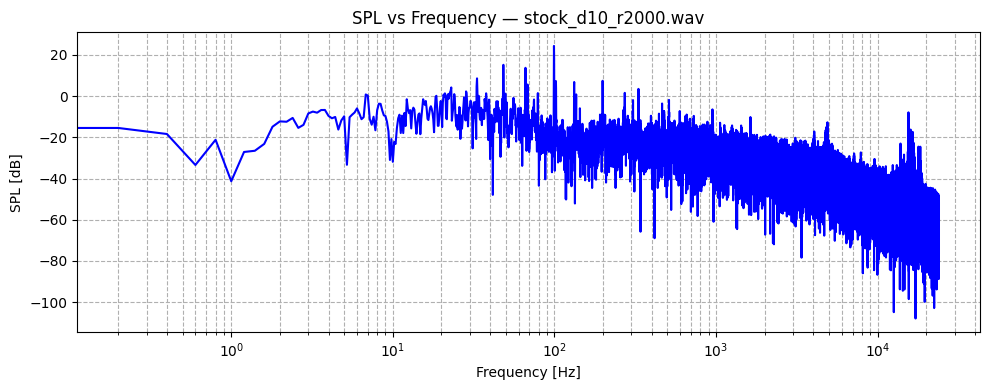

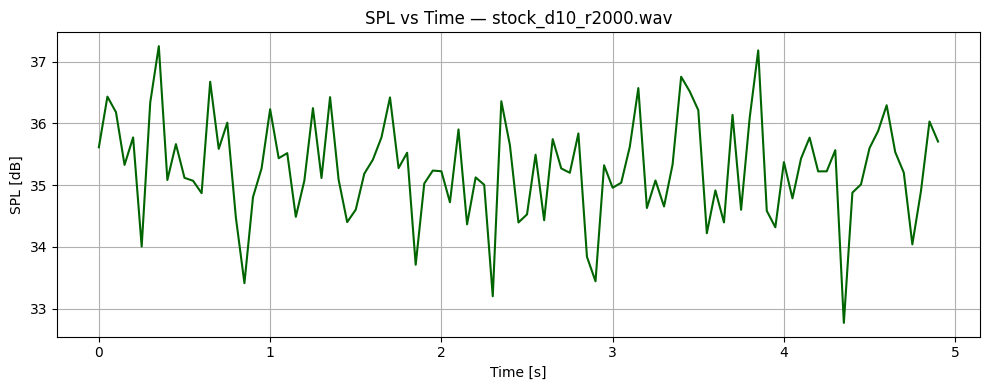

OASPL for stock_d10_r2000.wav: 35.35 dB



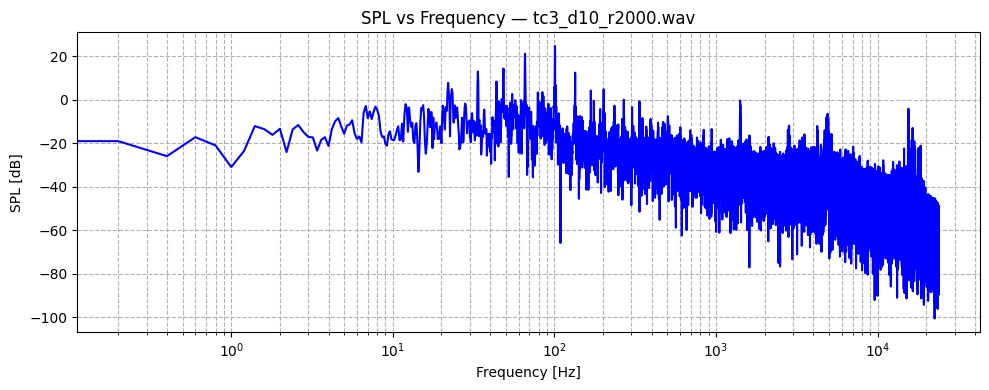

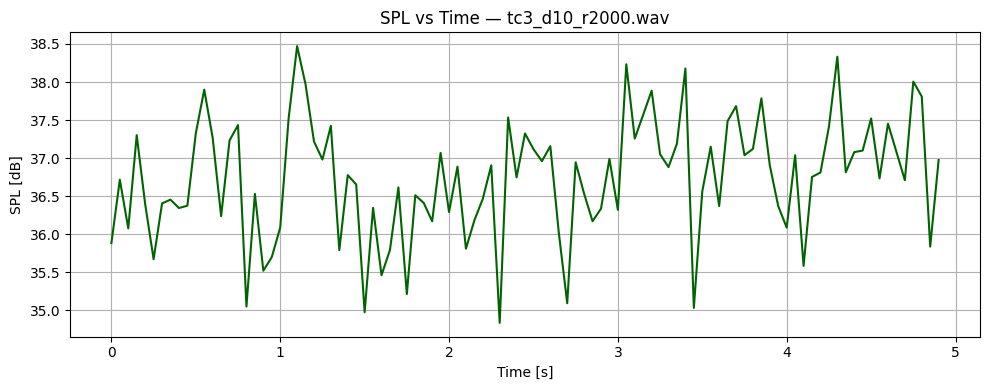

OASPL for tc3_d10_r2000.wav: 36.81 dB



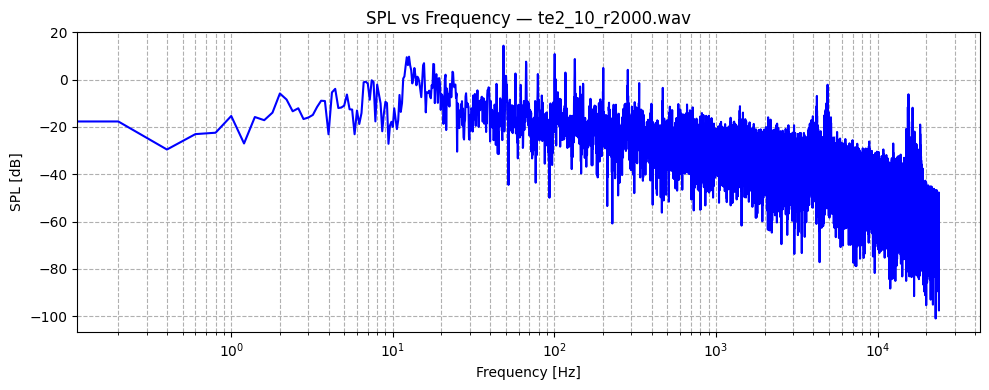

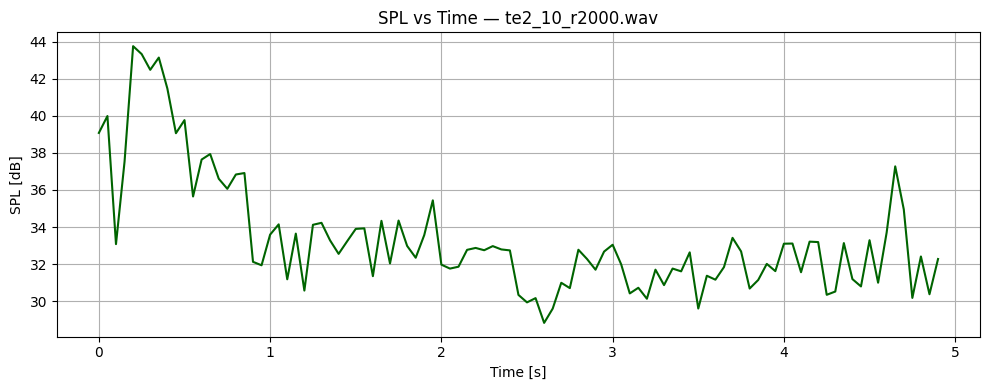

OASPL for te2_10_r2000.wav: 35.03 dB



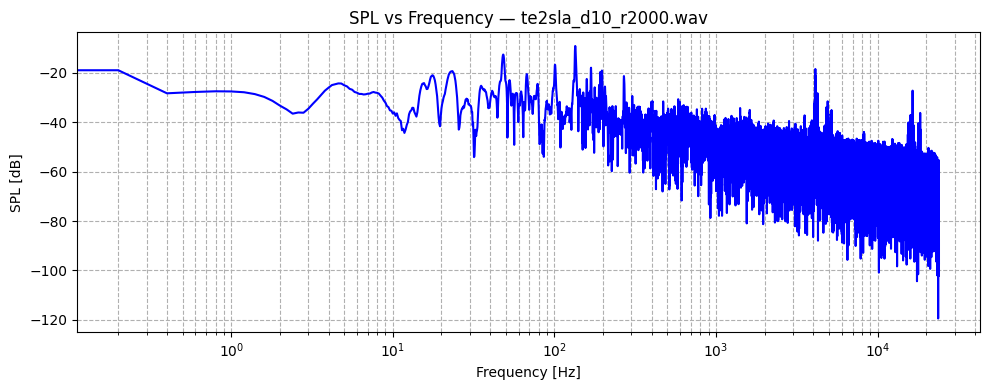

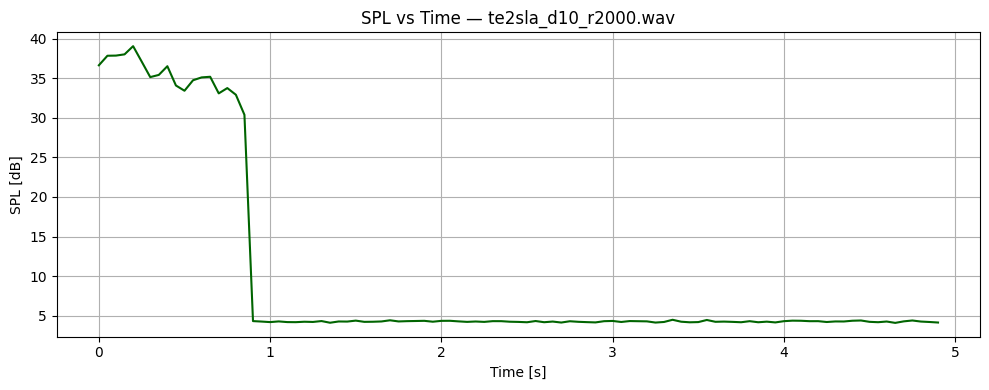

OASPL for te2sla_d10_r2000.wav: 28.42 dB



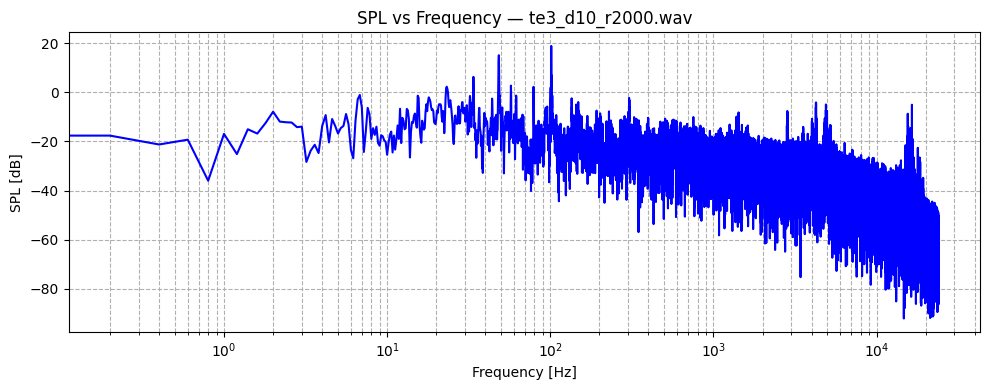

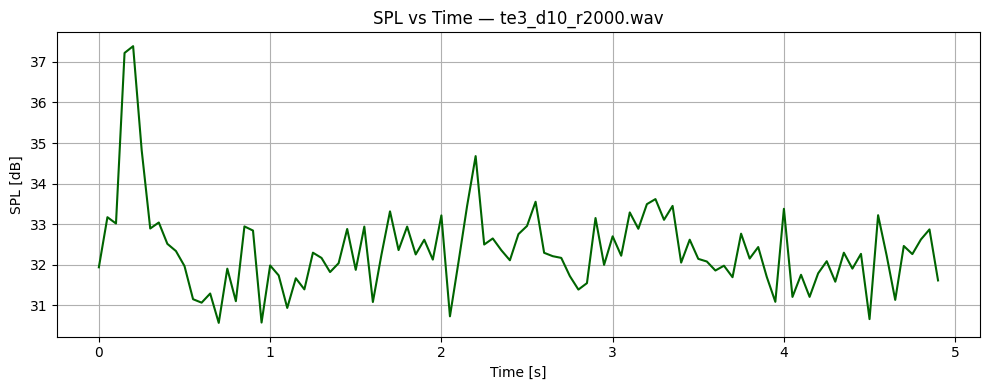

OASPL for te3_d10_r2000.wav: 32.52 dB



In [3]:
import numpy as np
import soundfile as sf
import scipy.signal as signal
import matplotlib.pyplot as plt
import os

# === Calibration File Reader ===
def read_calibration_file(calibration_path):
    data = np.loadtxt(calibration_path, skiprows=1)
    freqs, corrections = data[:, 0], data[:, 1]
    return lambda f: np.interp(f, freqs, corrections)

# === SPL Conversion ===
def compute_spl_db(value, ref=20e-6):
    return 20 * np.log10(np.abs(value) / ref + 1e-20)

# === OASPL ===
def compute_oaspl(pressure, ref=20e-6):
    rms = np.sqrt(np.mean(pressure ** 2))
    return 20 * np.log10(rms / ref + 1e-20)

# === SPL vs Frequency ===
def plot_spl_freq(pressure, samplerate, calib_func, file_label):
    window = np.hanning(len(pressure))
    fft_data = np.fft.rfft(pressure * window)
    freqs = np.fft.rfftfreq(len(pressure), 1/samplerate)
    magnitude = np.abs(fft_data) / len(pressure)

    # Apply calibration
    spl = compute_spl_db(magnitude)
    spl_calibrated = spl + calib_func(freqs)

    plt.figure(figsize=(10, 4))
    plt.semilogx(freqs, spl_calibrated, color='blue')
    plt.title(f"SPL vs Frequency — {file_label}")
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("SPL [dB]")
    plt.grid(True, which='both', ls='--')
    plt.tight_layout()
    plt.show()

# === SPL vs Time ===
def plot_spl_time(pressure, samplerate, file_label, window_duration=0.05):
    window_size = int(window_duration * samplerate)
    hop_size = window_size
    times, spl_values = [], []

    for i in range(0, len(pressure) - window_size, hop_size):
        segment = pressure[i:i+window_size]
        rms = np.sqrt(np.mean(segment**2))
        spl = 20 * np.log10(rms / 20e-6 + 1e-20)
        times.append(i / samplerate)
        spl_values.append(spl)

    plt.figure(figsize=(10, 4))
    plt.plot(times, spl_values, color='darkgreen')
    plt.title(f"SPL vs Time — {file_label}")
    plt.xlabel("Time [s]")
    plt.ylabel("SPL [dB]")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# === Process Each Audio File ===
def process_audio_file(file_path, calib_func):
    pressure, samplerate = sf.read(file_path)
    if pressure.ndim > 1:
        pressure = np.mean(pressure, axis=1)  # Convert to mono if stereo

    label = os.path.basename(file_path)

    plot_spl_freq(pressure, samplerate, calib_func, label)
    plot_spl_time(pressure, samplerate, label)

    oaspl = compute_oaspl(pressure)
    print(f"OASPL for {label}: {oaspl:.2f} dB\n")

# === Your Paths ===
calibration_file = r"/home/destrox-907/Husnian_FYP/AI_Code Files/hashim data/calibration file.txt"

wav_files = [
    r"/home/destrox-907/Husnian_FYP/AI_Code Files/hashim data/stock_d10_r2000.wav",
    r"/home/destrox-907/Husnian_FYP/AI_Code Files/hashim data/tc3_d10_r2000.wav",
    r"/home/destrox-907/Husnian_FYP/AI_Code Files/hashim data/te2_10_r2000.wav",
    r"/home/destrox-907/Husnian_FYP/AI_Code Files/hashim data/te2sla_d10_r2000.wav",
    r"/home/destrox-907/Husnian_FYP/AI_Code Files/hashim data/te3_d10_r2000.wav",
]

# === Run ===
calib_func = read_calibration_file(calibration_file)

for wav_path in wav_files:
    process_audio_file(wav_path, calib_func)
